## Import important libraries

In [ ]:
import random
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import rotate
from scipy import signal
from skimage.transform import resize

import matplotlib.pyplot as plt

from google.colab import drive
import os
import cv2

import json

<ipython-input-1-33498ec1d61d>:4: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


## Define a function which creates the snowy images (images with noise)

In [ ]:
def generate_snow_effect(input_img, std):
    img_shape = input_img.shape

    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    input_img = cv2.resize(input_img, dsize=(640, 640), interpolation=cv2.INTER_LINEAR)


    # SNOW_MIX_PARAMS
    SM_MEAN = 0.5  # mean for gaussian noise
    # SM_SD = 1.3 # standard deviation for gaussian noise
    SM_SD = std # standard deviation for gaussian noise
    SM_GAUSS_SD = 3 # gaussian blur standard deviation
    SM_SCALE_ARRAY = [.5, 1, 2, 3, 5]  # scale to determine motion blur kernel size

    SM_THRESH_RANGE = (.72, .78)  # threshold for gaussian noise map
    SM_ROTATE_RANGE = 60  # rotate range for motion blur kernel
    SM_NO_BLUR_FRAC = 0  # percent of time with no motion blur

    input_shape = input_img.shape[:2]  # Shape of the input image

    input_img = input_img.astype(np.float64)

    # SNOW MIX
    # final_mask = np.zeros_like(input_img)
    threshold = random.uniform(SM_THRESH_RANGE[0], SM_THRESH_RANGE[1])
    base_angle = random.uniform(-1 * SM_ROTATE_RANGE, SM_ROTATE_RANGE)

    for scale in SM_SCALE_ARRAY:
        # Generate snow layer with gaussian map thresholding
        inv_scale = 1 / scale
        layer = np.random.normal(SM_MEAN, SM_SD, (int(input_shape[0] * scale), int(input_shape[1] * scale)))
        layer = gaussian_filter(layer, sigma=SM_GAUSS_SD)
        layer = layer > threshold
        layer = resize(layer, input_shape)

        # motion blur
        kernel_size = random.randint(10, 15)
        angle = base_angle + random.uniform(-30, 30)  # angle for motion blur
        SM_KERNEL_SIZE = min(max(int(kernel_size * inv_scale), 3), 15)
        kernel_v = np.zeros((SM_KERNEL_SIZE, SM_KERNEL_SIZE))
        kernel_v[int((SM_KERNEL_SIZE - 1) / 2), :] = np.ones(SM_KERNEL_SIZE)
        kernel_v = rotate(kernel_v, 90 - angle)
        if scale > 4:
            kernel_v = gaussian_filter(kernel_v, sigma=1)
        elif scale < 1:
            kernel_v = gaussian_filter(kernel_v, sigma=3)
        else:
            kernel_v = gaussian_filter(kernel_v, sigma=int(4 - scale))
        kernel_v *= 1 / np.sum(kernel_v)
        if random.random() > SM_NO_BLUR_FRAC:
            layer = signal.convolve2d(layer, kernel_v, boundary='symm', mode='same')

        # blend with final mask

        layer = np.expand_dims(layer, axis = 2)

        # Blend the snow layer with the input image
        input_img = input_img * (1 - layer) + layer * 255

        input_img = np.clip(input_img, 0, 255)

    output_img = input_img/np.max(input_img)

    output_img = cv2.resize(output_img,dsize=(img_shape[1],img_shape[0]))

    return output_img


## Mount the drive and create the required folders to keep the data in the google drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the input folder containing images in Google Drive
ground_truth_folder = "/content/drive/My Drive/snow_effect_ground_truth"

# Path to the output folder for saving the resulting images in Google Drive
output_folder_1 = "/content/drive/My Drive/new_1.3_snow_effect_result"
output_folder_2 = "/content/drive/My Drive/new_1.4_snow_effect_result"

#bounding boxes data
bounding_box_data = "/content/drive/My Drive/traffic_bounding_box"

#labels
label_folder =  "/content/drive/My Drive/labels"

In [ ]:
# Create the folders if they doesn't exist
os.makedirs(ground_truth_folder, exist_ok=True)
os.makedirs(output_folder_1, exist_ok=True)
os.makedirs(output_folder_2, exist_ok=True)
os.makedirs(bounding_box_data, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)

## Download the traffic light dataset from hugging face

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

# Replace 'dataset_id' with the ID of the dataset you want to import
dataset = load_dataset('shpotes/bosch-small-traffic-lights-dataset')

In [ ]:
# Accessing the train split of the dataset --> we are taking only the train split of the dataset
train_dataset = dataset['train']
train_dataset

In [ ]:
#make a set to find the unique labels
unique_labels = set()

In [ ]:
for item in train_dataset:
  labels = item['boxes']['label']
  for label in labels:
    unique_labels.add(label)

In [ ]:
unique_labels

In [ ]:
num_images_to_display = 5

for i in range(num_images_to_display):
    # Get the image and its corresponding bounding boxes (if available)
    box_info = train_dataset[i+1000]['boxes']
    img = train_dataset[i+1000]['img']


    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(type(img))
    print(type(box_info))
    print((box_info))

## See some images with their bounding boxes (bounding box data must be in the form as obtained from the huggingface dataset)

In [ ]:
import cv2

def draw_bounding_boxes(image, boxes_data):
    # Convert image to BGR (OpenCV uses BGR color format)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Iterate over bounding box data
    for label, x_min, y_min, x_max, y_max in zip(boxes_data['label'], boxes_data['x_min'], boxes_data['y_min'], boxes_data['x_max'], boxes_data['y_max']):
        # Convert coordinates to integers
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

        # Draw rectangle on the image
        cv2.rectangle(image_bgr, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green rectangle with thickness 2

        # Add label text
        cv2.putText(image_bgr, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert image back to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    return image_rgb

In [ ]:
img = np.array(train_dataset[0]['img'])
box_info = train_dataset[0]['boxes']

img_with_box = draw_bounding_boxes(img,box_info)

In [ ]:
plt.imshow(img_with_box)

## Apply the snow effect on the images and save the images as well as the snowy images in the google drive

In [ ]:
# Apply snow effect to each image and save them to the output folder
for i, sample in enumerate(train_dataset):
    # Get the image from the dataset
    input_image = np.array(sample['img'])

    # save the image in the ground truth folder
    ground_truth_name = os.path.join(ground_truth_folder, f"image_{i}.jpg")
    plt.imsave(ground_truth_name, input_image)

    # convert the image from rgb to bgr so that they can be obtained in rgb after applying the generate_snow_effect (it converts a bgr image to rgb)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    # Apply the snow effect on the original image
    result_image_1 = generate_snow_effect(input_image,1.3)

    # Save the resulting image to the output folder
    output_filename_1 = os.path.join(output_folder_1, f"image_{i}.jpg")
    plt.imsave(output_filename_1, result_image_1)

    # Apply the snow effect again on the original image with slightly different settings
    result_image_2 = generate_snow_effect(input_image,1.4)

    # Save the resulting image to the output folder
    output_filename_2 = os.path.join(output_folder_2, f"image_{i}.jpg")
    plt.imsave(output_filename_2, result_image_2)

    if(i%50==0):
      print(i,"images have been generated and now only",5093-i,"images are left")

print("Snow effect applied to all images and saved in the 'snow_effect_result' folders in Google Drive.")

## Save the bounding boxes data in a json file to use it later

In [ ]:
box_data = []

In [ ]:
# add the box data into a list
for i,sample in enumerate(train_dataset):
    box_data.append(sample['boxes'])
    if(i%50==0):
      print(i,"box data added",5093-i,"remaining")

In [ ]:
small_box_data = box_data[:3550]

In [ ]:
# define the functions to save and load the json file

def save_boxes_data(boxes_data, file_path):
    with open(file_path, 'w') as f:
        json.dump(boxes_data, f)

def load_boxes_data(file_path):
    with open(file_path, 'r') as f:
        boxes_data = json.load(f)
    return boxes_data

In [ ]:
# save the bounding box data
file_path = os.path.join(bounding_box_data,"boxes_data.json")

# Save the combined boxes data to the file
save_boxes_data(small_box_data, file_path)

In [ ]:
# load the bounding box data
file_path = os.path.join(bounding_box_data,"boxes_data.json")

# Load the boxes data from the file
loaded_boxes_data = load_boxes_data(file_path)

# YOLOv7

## Conversion of the data to YOLO format

In [ ]:
total_data = []

In [ ]:
cnt = 0

#loop to get all the images in a single json file
for i in range(3550): #only get the 3550 images
    ground_img = cv2.imread(os.path.join(ground_truth_folder,f'image_{i}.jpg'))
    ground_img = cv2.cvtColor(ground_img, cv2.COLOR_BGR2RGB)

    output_img_1 = cv2.imread(os.path.join(output_folder_1,f'image_{i}.jpg'))
    output_img_1 = cv2.cvtColor(output_img_1, cv2.COLOR_BGR2RGB)

    output_img_2 = cv2.imread(os.path.join(output_folder_2,f'image_{i}.jpg'))
    output_img_2 = cv2.cvtColor(output_img_2, cv2.COLOR_BGR2RGB)

    box_data = small_box_data[i]

    sample_dict = {'ground_truth':ground_img, 'output_1.3':output_img_1, 'output_1.4':output_img_2, 'box_data':box_data}

    total_data.append(sample_dict)

    cnt+=1

    if(cnt%50 == 0):
      print(i,"box data added",5093-i,"remaining")

In [ ]:
# format the data in the YOLO format

# Class name mapping
class_name_mapping = {
    'Green': 0,
    'GreenLeft': 1,
    'GreenRight': 2,
    'GreenStraight': 3,
    'GreenStraightLeft': 4,
    'GreenStraightRight': 5,
    'Red': 6,
    'RedLeft': 7,
    'RedRight': 8,
    'RedStraight': 9,
    'RedStraightLeft': 10,
    'Yellow': 11,
    'off': 12
}

# Function to calculate the required values
def calculate_values(x_min, x_max, y_min, y_max, w_img, h_img):
    width = x_max - x_min
    height = y_max - y_min
    x_center = (x_min + width / 2) / w_img
    y_center = (y_min + height / 2) / h_img
    width /= w_img
    height /= h_img
    return x_center, y_center, width, height

In [ ]:
# Process each dictionary and write to a .txt file
cnt = 0
for index, item in enumerate(loaded_boxes_data):

    # Load the image to get its dimensions
    img = cv2.imread(os.path.join(ground_truth_folder,f'image_{index}.jpg'))
    h_img, w_img, _ = img.shape

    output_file_path = os.path.join(label_folder, f'image_{index}.txt')

    # Open a new .txt file for writing
    with open(output_file_path, 'w') as file:
        for label, x_min, x_max, y_min, y_max in zip(item['label'], item['x_min'], item['x_max'], item['y_min'], item['y_max']):
            # Get the class id
            class_id = class_name_mapping[label]
            # Calculate the required values
            x_center, y_center, width, height = calculate_values(x_min, x_max, y_min, y_max, w_img, h_img)
            # Write to the file
            file.write(f'{class_id} {x_center} {y_center} {width} {height}\n')


    cnt+=1
    if(cnt%10==0):
      print(cnt, "done and only", 3550 - cnt, "are left")



print("Files have been created successfully.")

In [ ]:
cnt = 0
empty_label_indices = []

for index, item in enumerate(loaded_boxes_data):
    if(len(item['label'])==0):
      empty_label_indices.append(index)
      print(index, "This is the item label",item['label'])
      cnt += 1

print("---------------------")
print(cnt, "are empty")

In [ ]:
#create another folder called training folder
train_folder = "/content/drive/My Drive/training_data"
os.makedirs(train_folder, exist_ok=True)

In [ ]:
train_image_folder = "/content/drive/My Drive/training_data/images"
train_label_folder = "/content/drive/My Drive/training_data/labels"
os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(train_label_folder, exist_ok=True)

In [ ]:
image_files = os.listdir(ground_truth_folder)
label_files = os.listdir(label_folder)

# Sort the image files numerically based on their names
sorted_image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
sorted_label_files = sorted(label_files, key=lambda x: int(x.split('_')[1].split('.')[0]))


In [ ]:
import shutil

In [ ]:
# Adding only those files in the data for training which have labels
cnt = 0

for img, label in zip(sorted_image_files, sorted_label_files):
    index = int(img.split('_')[1].split('.')[0])

    if(index not in empty_label_indices):
      img_path = os.path.join(ground_truth_folder,f'image_{index}.jpg')
      label_path = os.path.join(label_folder,f'image_{index}.txt')

      #file to copy
      img_copy_path = os.path.join(train_image_folder,f'{cnt}.jpg')
      label_copy_path = os.path.join(train_label_folder,f'{cnt}.txt')

      shutil.copy(img_path, img_copy_path)
      shutil.copy(label_path, label_copy_path)

      cnt+=1

      print(index, "is copied to ",cnt)

    if(cnt%50 == 0):
      print(cnt,"done")

## Create the YAMl file for the YOLO training

In [ ]:
train_image_folder = "/content/drive/My Drive/training_data/images"
train_label_folder = "/content/drive/My Drive/training_data/labels"

In [ ]:
image_files = os.listdir(train_image_folder)
label_files = os.listdir(train_label_folder)

# Sort the image files numerically based on their names
sorted_image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))
sorted_label_files = sorted(label_files, key=lambda x: int(x.split('.')[0]))

NameError: name 'os' is not defined

In [ ]:
train_set = int(len(sorted_image_files)*0.7) #taking 70% of the data for training

In [ ]:
# create the train.txt and the valid.txt

count = 0
for i in sorted_image_files:
  img_path = os.path.join(train_image_folder, i)
  if(count<train_set):
    with open('/content/drive/My Drive/train.txt','a') as x:
      x.write(img_path + '\n')
  else:
    with open('/content/drive/My Drive/valid.txt','a') as x:
      x.write(img_path + '\n')

  count += 1

In [ ]:
# import yaml

# # Define the data
# data = {
#     'train': '/content/drive/My Drive/train.txt',
#     'val': '/content/drive/My Drive/valid.txt',
#     'nc': 13,
#     'names': ['Green', 'GreenLeft', 'GreenRight', 'GreenStraight', 'GreenStraightLeft', 'GreenStraightRight', 'Red', 'RedLeft', 'RedRight', 'RedStraight', 'RedStraightLeft', 'Yellow', 'off']
# }

# # Specify the file path for the YAML file
# yaml_file_path = '/content/drive/My Drive/data.yaml'

# # Dump the data dictionary into a YAML file
# with open(yaml_file_path, 'w') as yaml_file:
#     yaml.dump(data, yaml_file, sort_keys = False)

# print("data.yaml file created successfully.")


<hr>

# YOLOv7 TRAINING

## Start the training using the YOLOv7 model

In [ ]:
# Download YOLOv7 repository and install requirements
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197
Receiving objects: 100% (1197/1197), 74.23 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (519/519), done.


In [ ]:
%cd yolov7
#changes the current working directory to 'yolov7', this is necessary to navigate into the cloned repository

!pip install -r requirements.txt
#runs and installs the dependencies mentioned in the requirements.txt in the cloned repo

/content/yolov7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.10

In [ ]:
# download COCO starting checkpoint
%cd /content/yolov7

!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

In [ ]:
# run this cell to begin training
%cd /content/yolov7

# provide the path of the data.yaml file and the starting weights --> COCO starting checkpoint
!python train.py --batch 16 --epochs 50 --data '/content/drive/My Drive/data.yaml' --weights 'yolov7_training.pt' --device 0

In [ ]:
# save the weights  --> make a folder to save the weights
!mkdir -p '/content/drive/My Drive/weights/'

In [ ]:
#now copy the weights
!cp /content/yolov7/runs/train/exp/weights/best.pt '/content/drive/My Drive/weights/'

## Run inference on all the three set of images

In [ ]:
%cd /content/yolov7

# use the weight obtained after training on the above dataset
!python detect.py --weights '/content/drive/MyDrive/weights/best.pt' --conf 0.3 --source '/content/drive/MyDrive/snow_effect_ground_truth/'

/content/yolov7
Namespace(weights=['/content/drive/MyDrive/weights/best.pt'], source='/content/drive/MyDrive/snow_effect_ground_truth/', img_size=640, conf_thres=0.3, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.2.1+cu121 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36546500 parameters, 6194944 gradients, 103.4 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved!

In [ ]:
# use the weight obtained after training on the above dataset
!python detect.py --weights '/content/drive/MyDrive/weights/best.pt' --conf 0.3 --source '/content/drive/MyDrive/new_1.3_snow_effect_result/'

In [ ]:
# use the weight obtained after training on the above dataset
!python detect.py --weights '/content/drive/MyDrive/weights/best.pt' --conf 0.3 --source '/content/drive/MyDrive/new_1.4_snow_effect_result/'

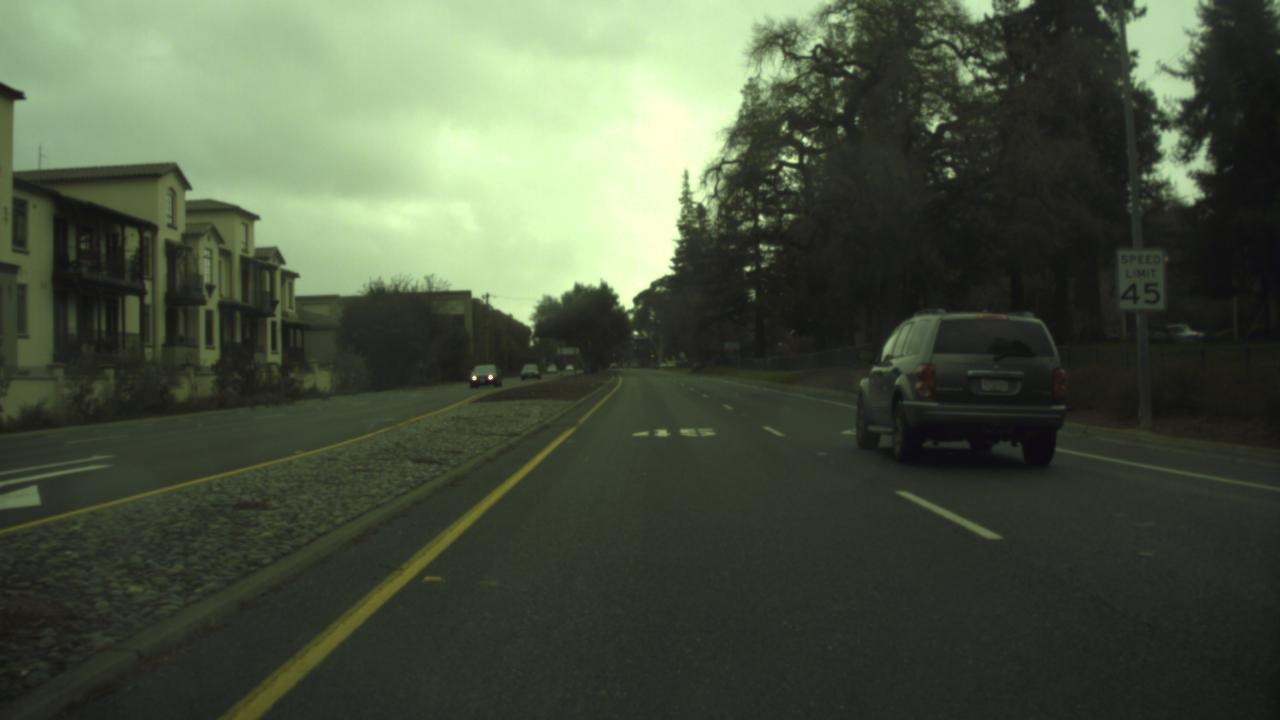

/content/yolov7/runs/detect/exp/image_1.jpg




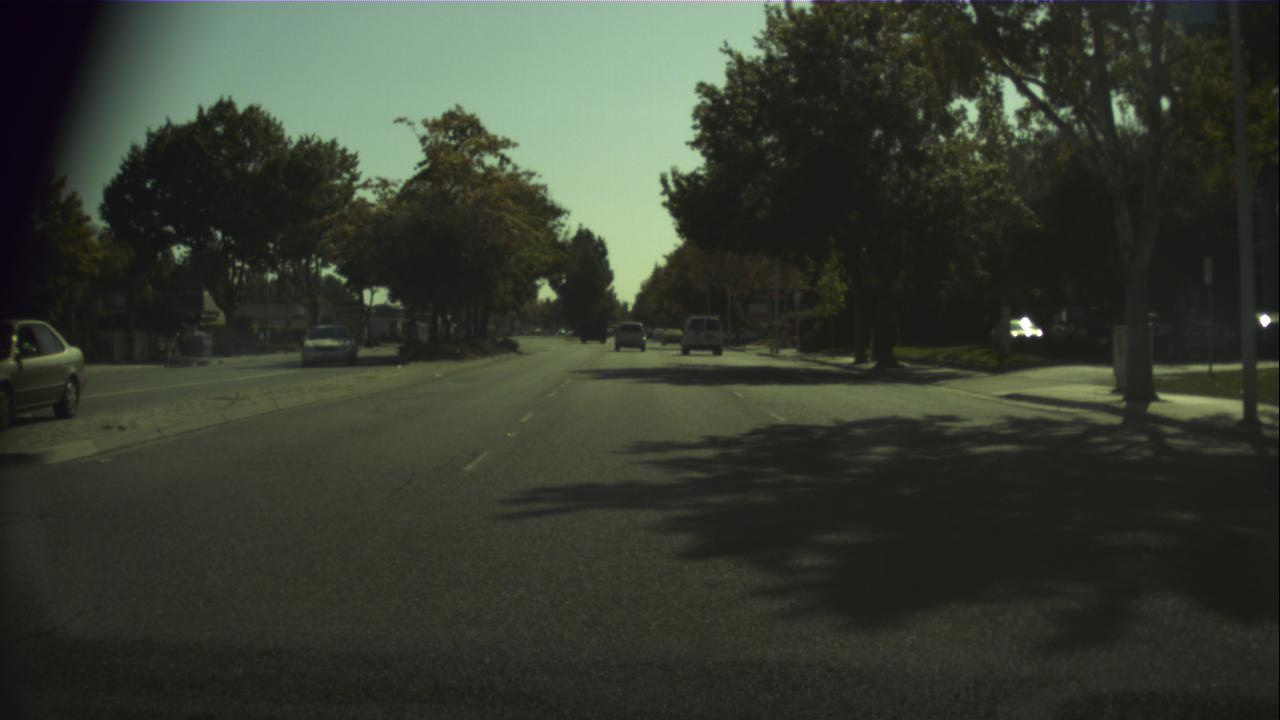

/content/yolov7/runs/detect/exp/image_1006.jpg




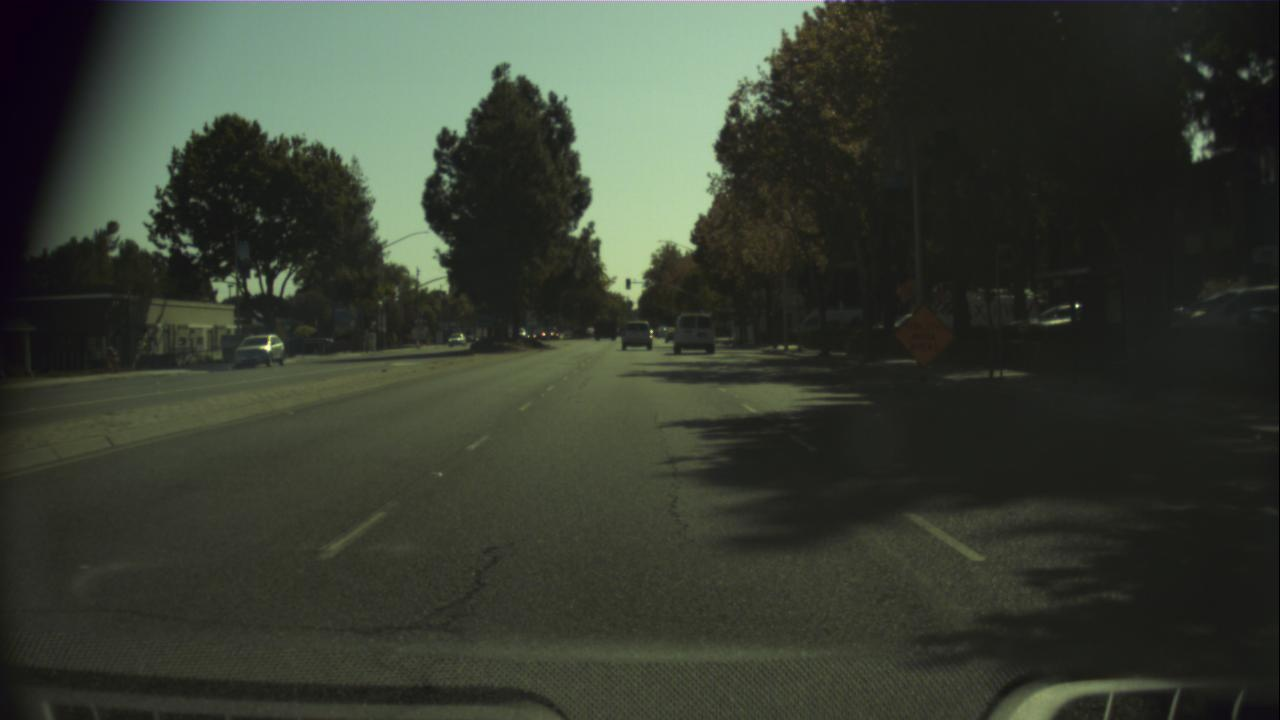

/content/yolov7/runs/detect/exp/image_1010.jpg




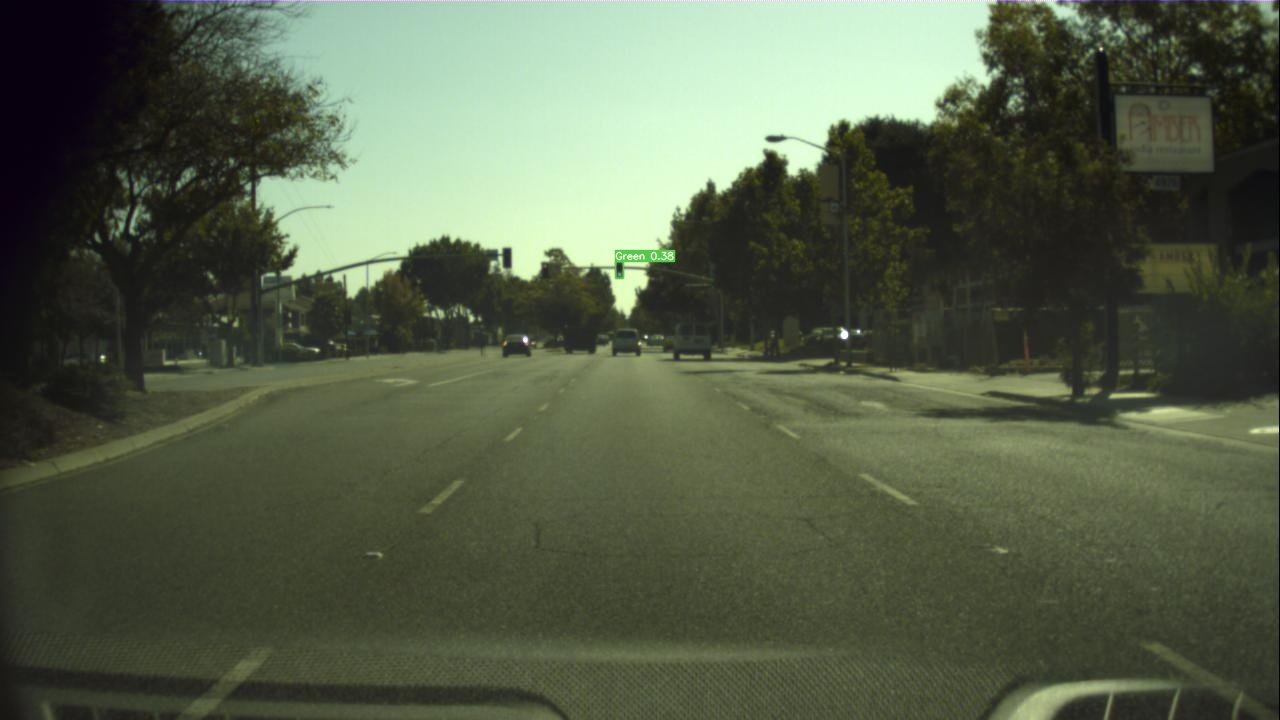

/content/yolov7/runs/detect/exp/image_1003.jpg




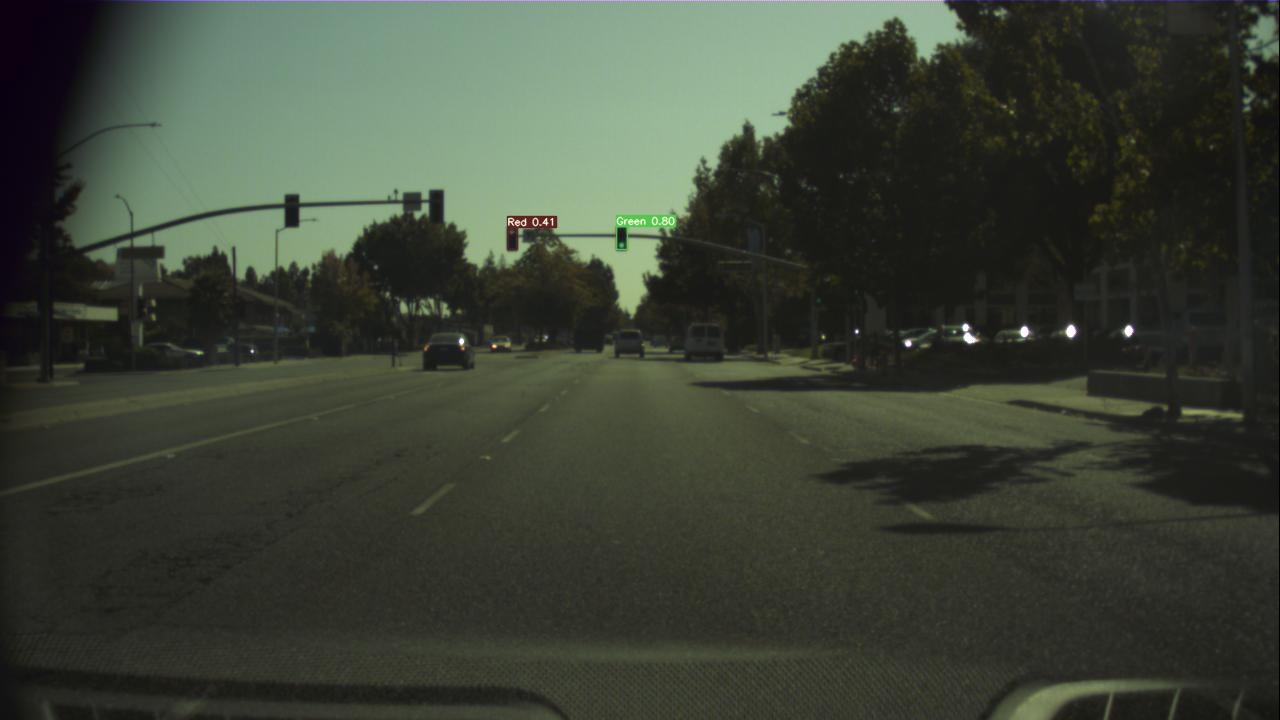

/content/yolov7/runs/detect/exp/image_1004.jpg




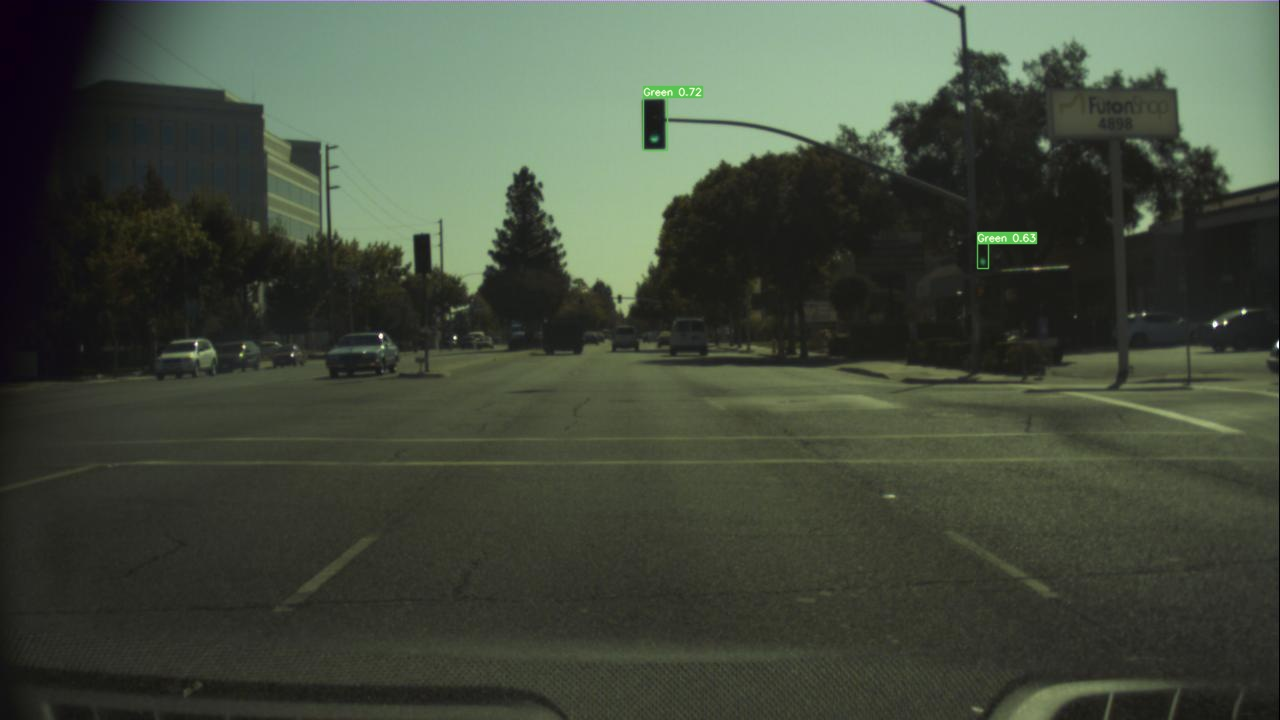

/content/yolov7/runs/detect/exp/image_1000.jpg




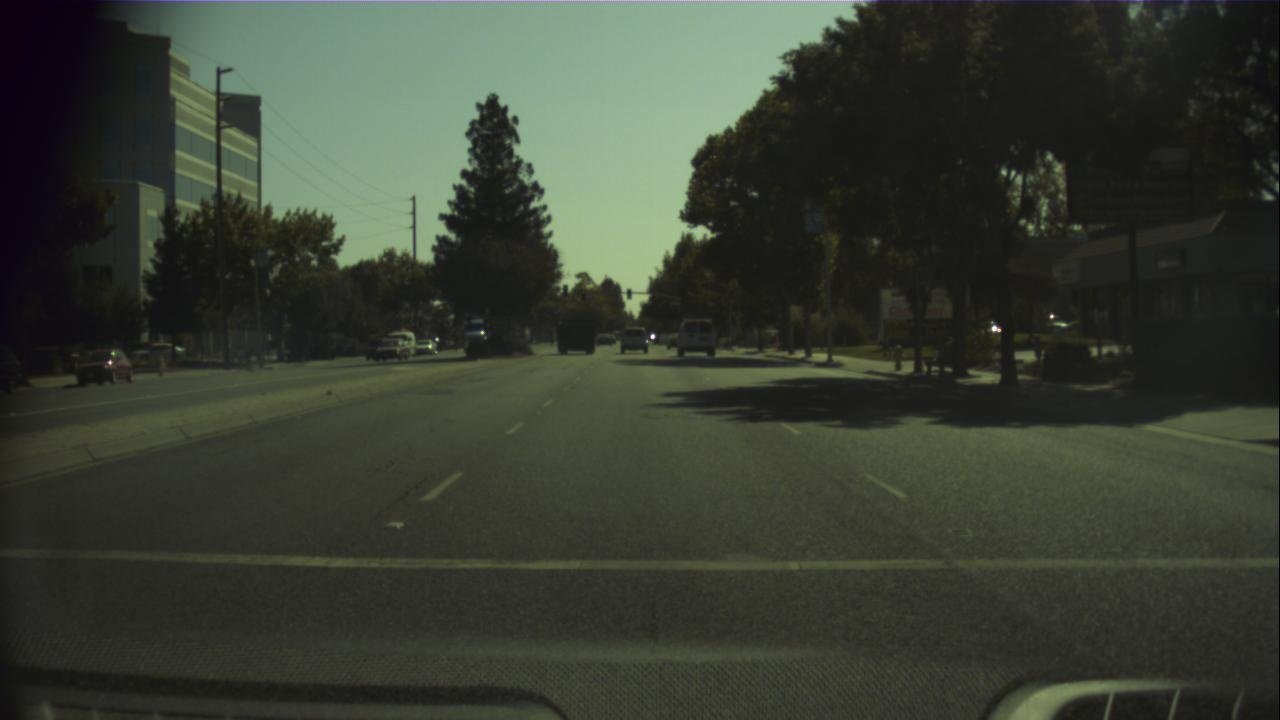

/content/yolov7/runs/detect/exp/image_1001.jpg




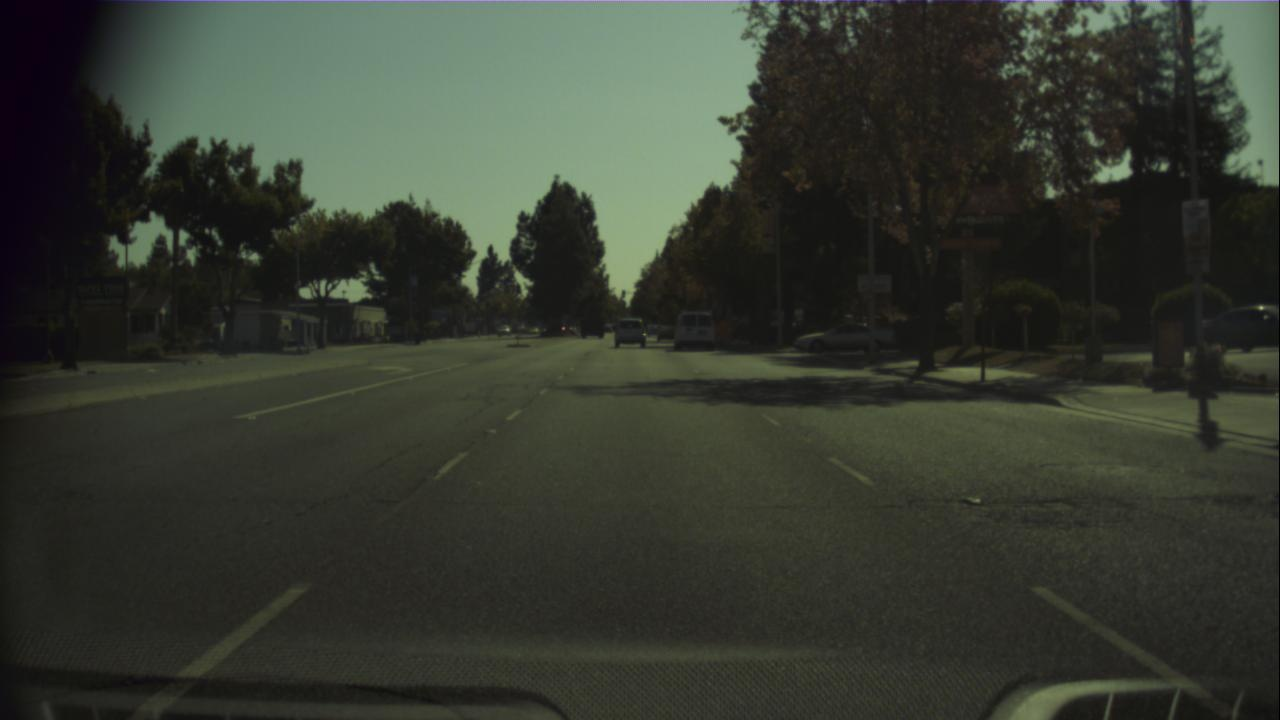

/content/yolov7/runs/detect/exp/image_1008.jpg




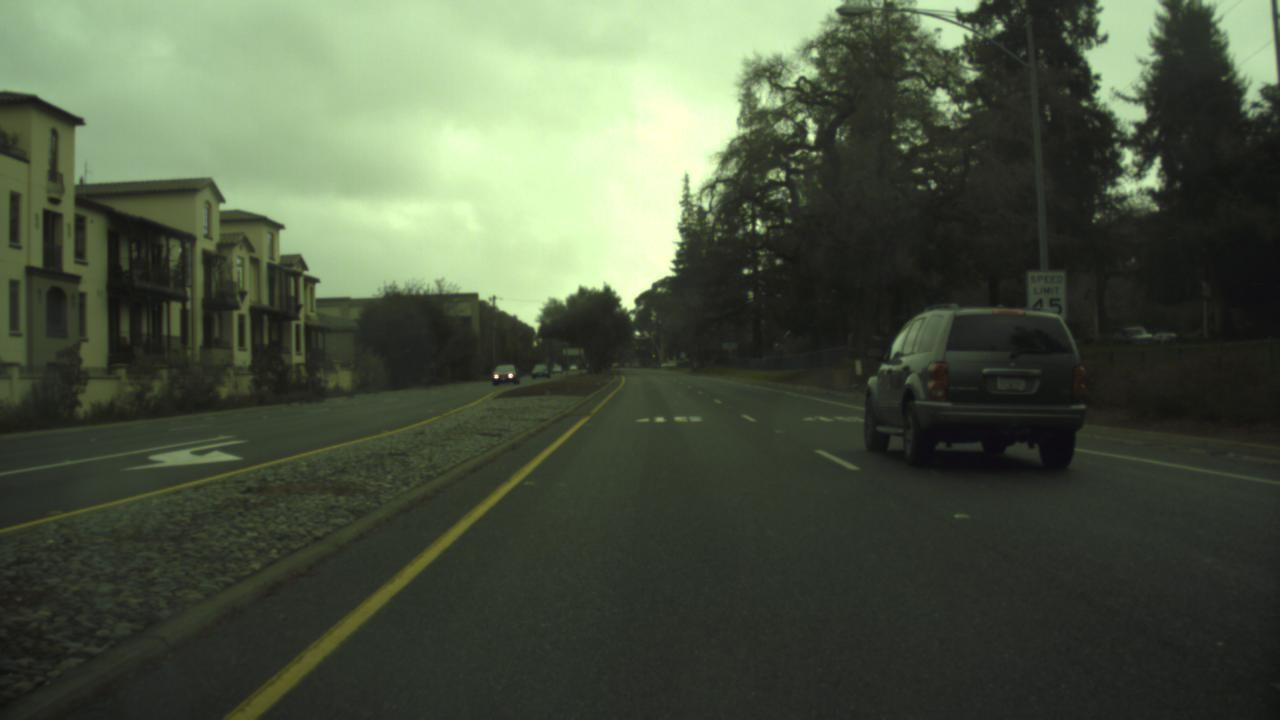

/content/yolov7/runs/detect/exp/image_0.jpg




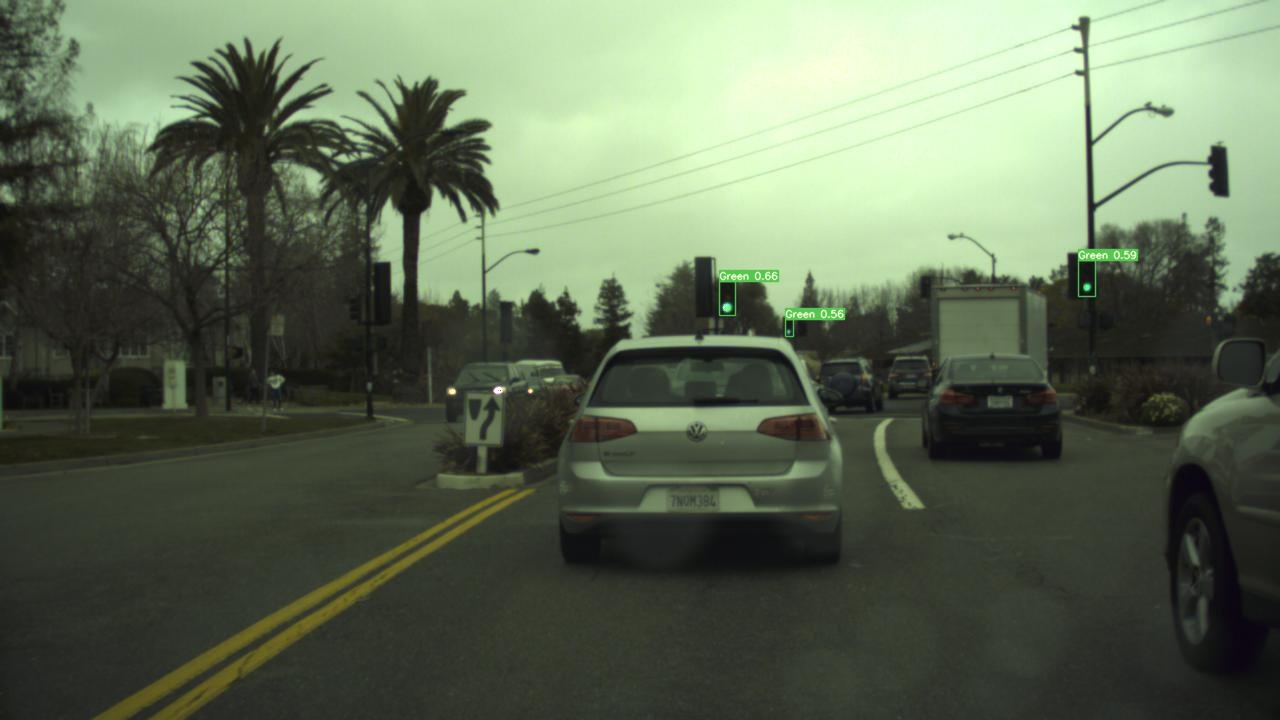

/content/yolov7/runs/detect/exp/image_100.jpg




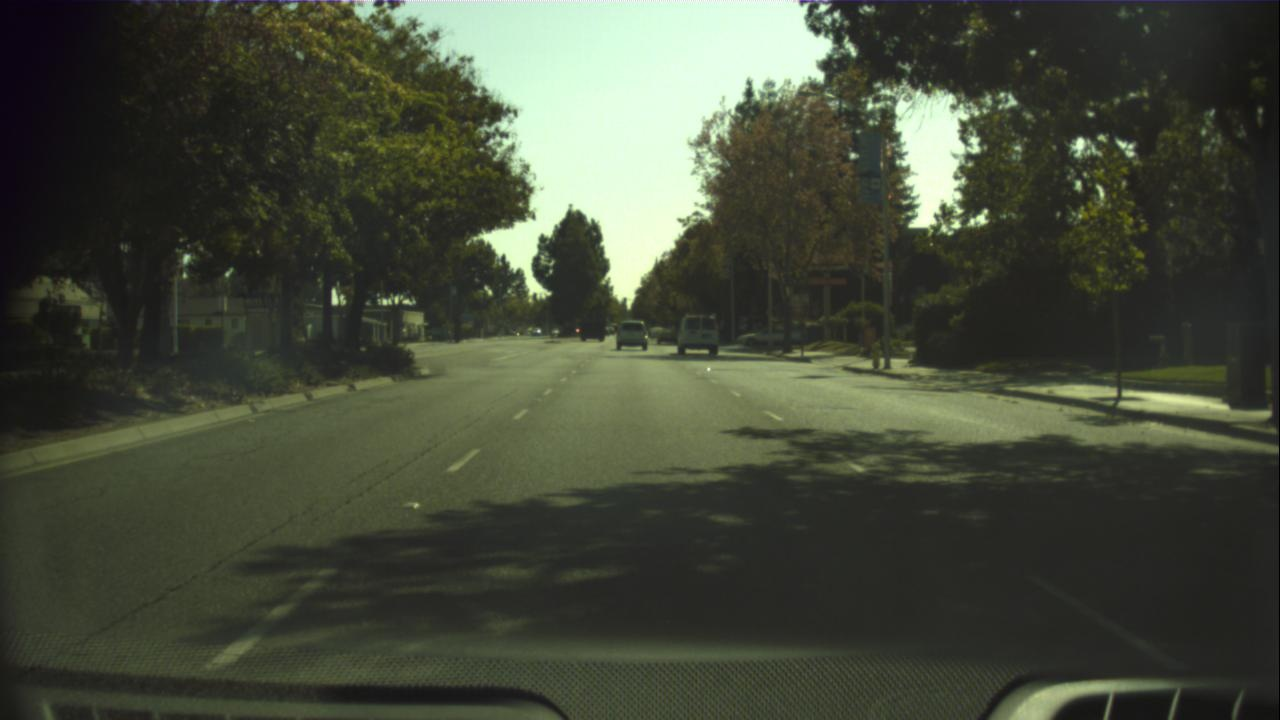

/content/yolov7/runs/detect/exp/image_1007.jpg




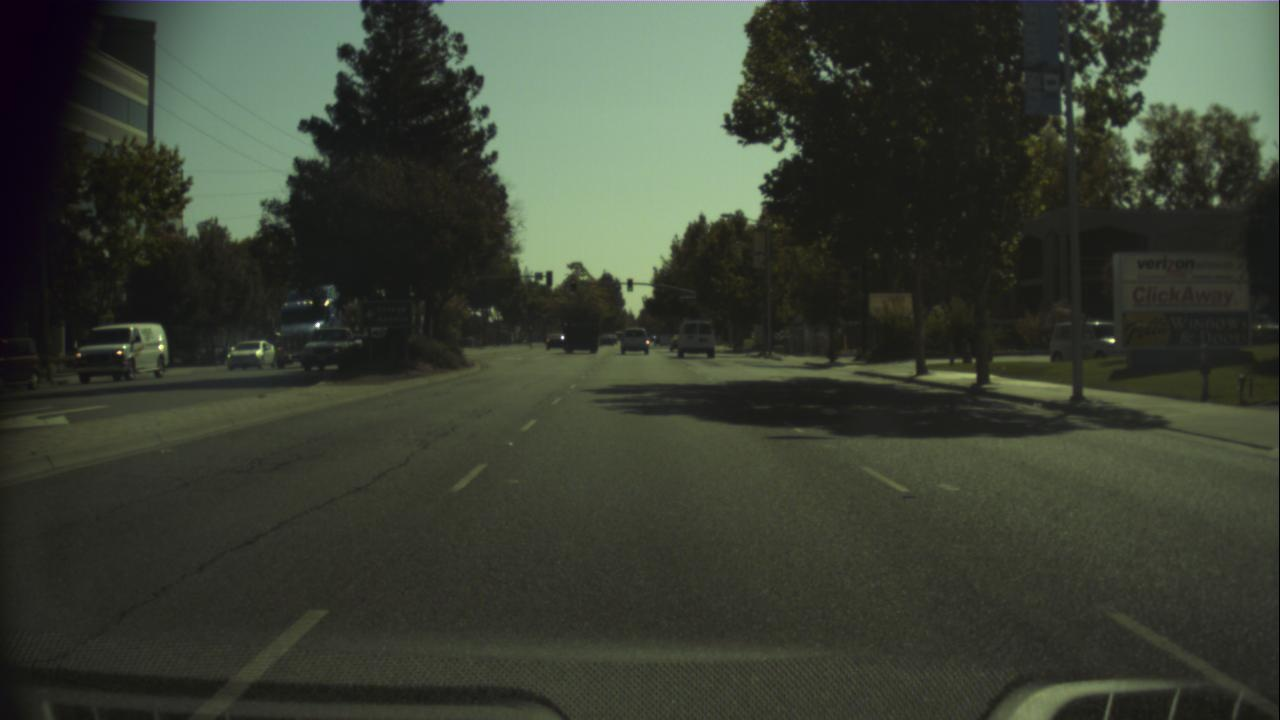

/content/yolov7/runs/detect/exp/image_1002.jpg




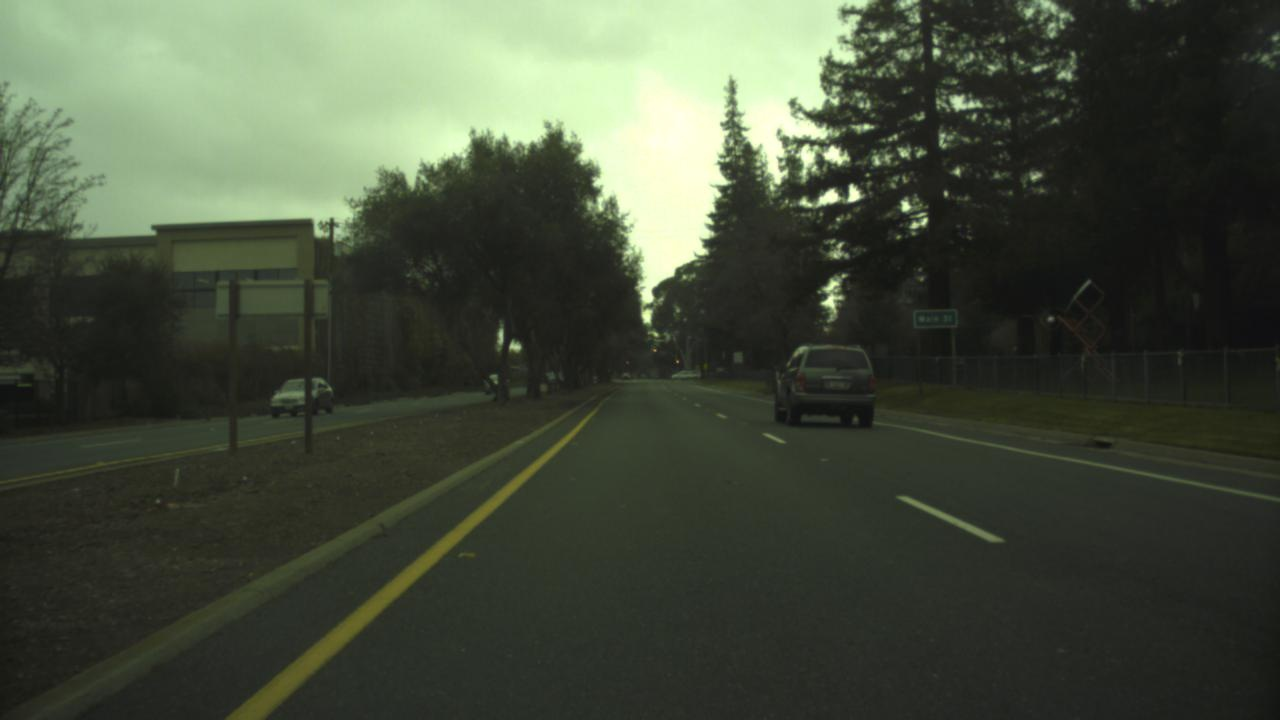

/content/yolov7/runs/detect/exp/image_10.jpg




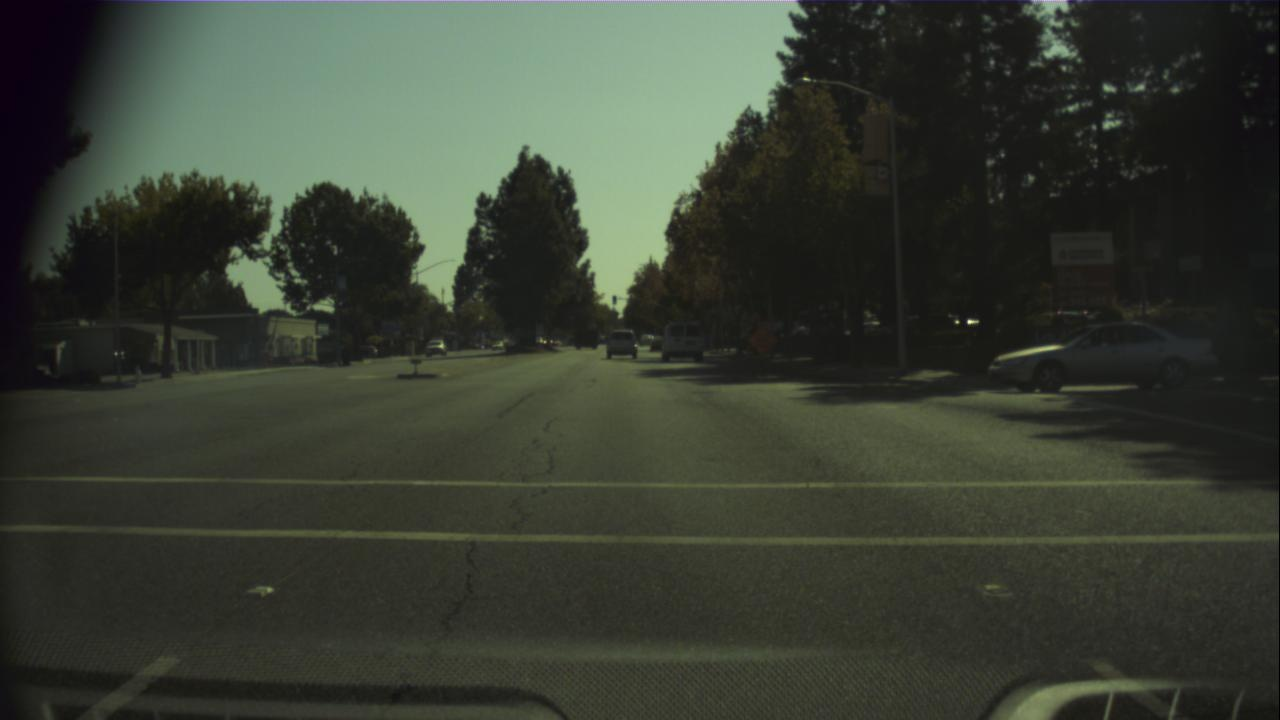

/content/yolov7/runs/detect/exp/image_1009.jpg




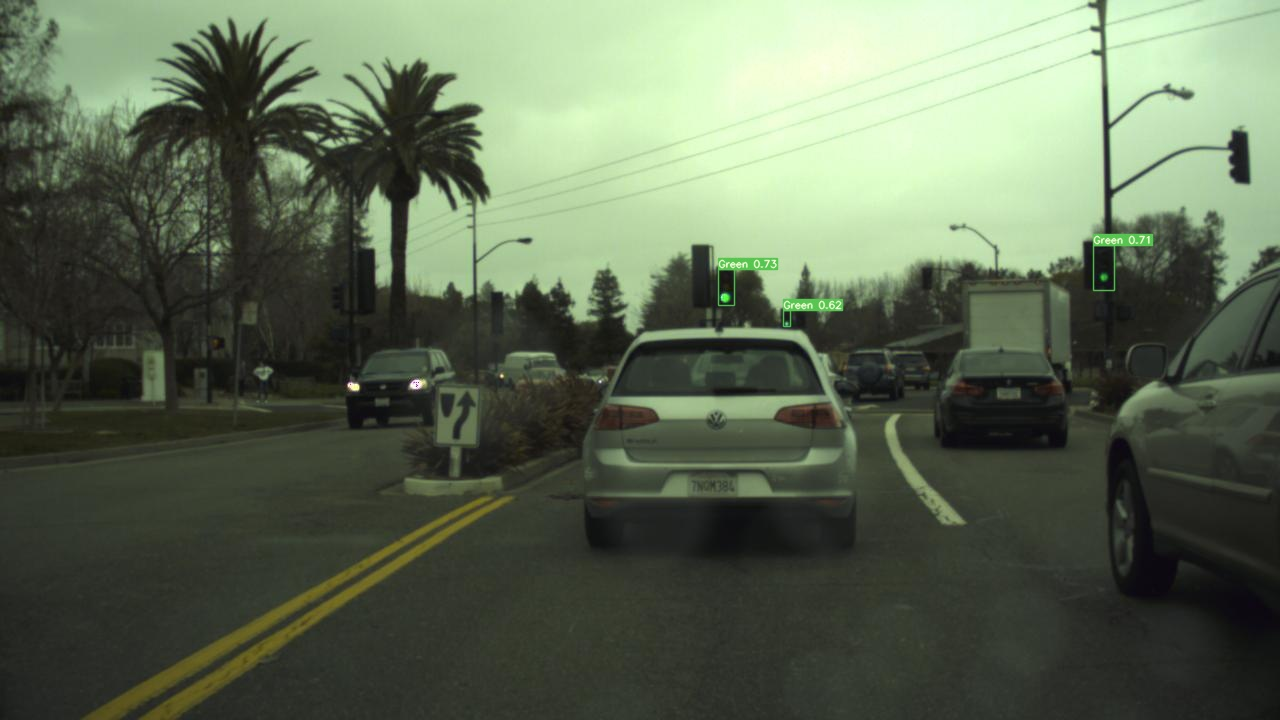

/content/yolov7/runs/detect/exp/image_101.jpg




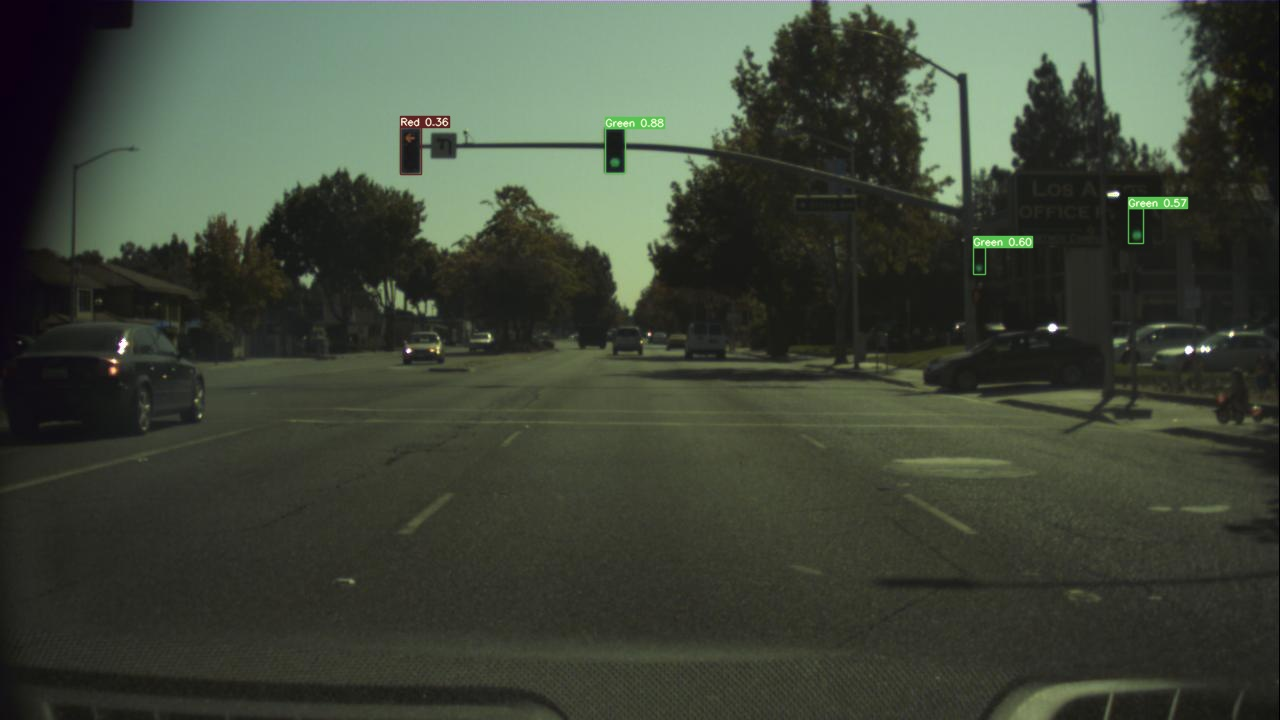

/content/yolov7/runs/detect/exp/image_1005.jpg




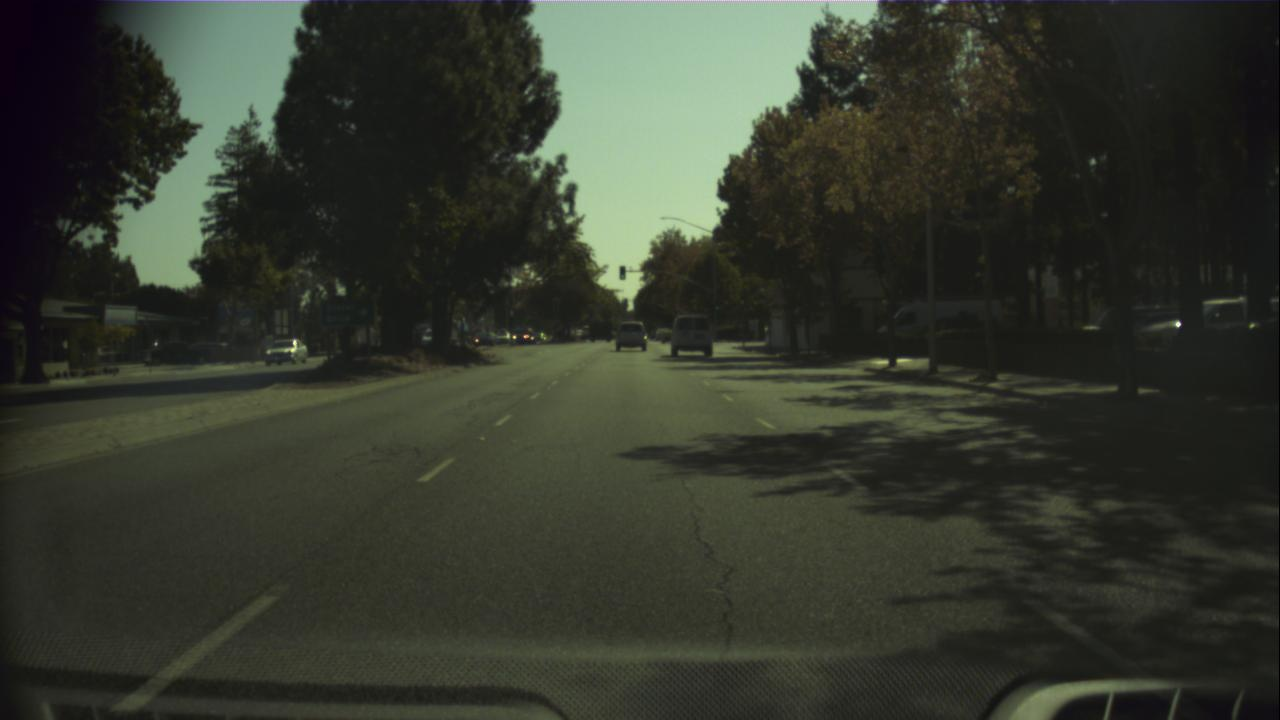

/content/yolov7/runs/detect/exp/image_1011.jpg




In [ ]:
#display inference on some of the test images

import glob
from IPython.display import Image, display

i = 0
limit = 20 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #assuming JPG (check in which format they are saved using the file directory of YOLO)
    if i < limit:
      display(Image(filename=imageName))
      print(imageName)
      print("\n")
    i = i + 1

## Visualize the results on all the sets side by side

In [ ]:
ground_truth = os.listdir('/content/yolov7/runs/detect/exp')
light_snow = os.listdir('/content/yolov7/runs/detect/exp2')
heavy_snow = os.listdir('/content/yolov7/runs/detect/exp3')

# Sort the image files numerically based on their names
ground_truth = sorted(ground_truth, key=lambda x: int(x.split('_')[1].split('.')[0]))
light_snow = sorted(light_snow, key=lambda x: int(x.split('_')[1].split('.')[0]))
heavy_snow = sorted(heavy_snow, key=lambda x: int(x.split('_')[1].split('.')[0]))

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images(images, titles=None, figsize=(15, 20)):
    num_images = len(images)
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    for i, (image, ax) in enumerate(zip(images, axes)):
        ax.imshow(image)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [ ]:
cnt = 0
titles = ['Ground truth','Light snow','Heavy snow']

random_integers = [random.randint(0, 3549) for _ in range(10)]

# for i in random_integers:
for i in [123,425,2893,2273,2215,3215,3283,1146,1344,3136,3232,3335,518,2967,1783,541,501,2311,259,3486]:
  filename = f'image_{i}.jpg'
  image1 = np.array(Image.open(os.path.join('/content/yolov7/runs/detect/exp',filename)))
  image2 = np.array(Image.open(os.path.join('/content/yolov7/runs/detect/exp2',filename)))
  image3 = np.array(Image.open(os.path.join('/content/yolov7/runs/detect/exp3',filename)))

  images = [image1,image2,image3]

  titles_modify = [title + " " + filename for title in titles]

  display_images(images, titles_modify)

  cnt += 1

  if(cnt==10):
    break

<hr>

# DETECTRON MODEL BY FACEBOOK

## Installation and importing some important libraries

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

# other libs (other necessary imports in Colab file to make the list shorter here)

import torch, torchvision
import torchvision.transforms as transforms

## Converting data from YOLO format to COCO format, since Detectron works on COCO format data

In [ ]:
def read_file_names_from_txt(txt_file):
    file_names = []
    with open(txt_file, 'r') as f:
        for line in f:
            file_name = line.strip().split('/')[-1].split('.')[0]
            img_path = f'/content/drive/MyDrive/training_data/images/{file_name}.jpg'
            label_path = f'/content/drive/MyDrive/training_data/labels/{file_name}.txt'

            file_names.append([img_path, label_path])
    return file_names

In [ ]:
train_txt_file = '/content/drive/MyDrive/train.txt' #Path to the train.txt file
train = read_file_names_from_txt(train_txt_file)

valid_txt_file = '/content/drive/MyDrive/valid.txt'
val = read_file_names_from_txt(valid_txt_file)

In [ ]:
# convert the data from YOLO format to COCO format (since detectron does not work on the YOLO format)
def create_coco_format(data_pairs):

    data_list = []

    for i, path in enumerate(data_pairs):

        filename = path[0]

        img_h, img_w = cv2.imread(filename).shape[:2]

        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w

        print(str(i), filename)

        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')

                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])

                # print(class_id, x_c, y_c, width, height)

                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h

                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_id),
                    "iscrowd": 0
                }
                annotations.append(annotation)
            img_item["annotations"] = annotations
        data_list.append(img_item)
    return data_list

In [ ]:
print("Converting the training data to COCO format")
train_list = create_coco_format(train)

print('---------------------------------------------------')

print("Converting the validation data to COCO format")
val_list = create_coco_format(val)

In [ ]:
import json

def save_list_of_dicts_to_file(list_of_dicts, file_path):
    with open(file_path, 'w') as f:
        json.dump(list_of_dicts, f)

def load_list_of_dicts_from_file(file_path):
    with open(file_path, 'r') as f:
        list_of_dicts = json.load(f)
    return list_of_dicts

In [ ]:
save_list_of_dicts_to_file(train_list,'/content/drive/MyDrive/train_coco.json')
save_list_of_dicts_to_file(val_list,'/content/drive/MyDrive/valid_coco.json')

In [ ]:
train_list = load_list_of_dicts_from_file('/content/drive/MyDrive/train_coco.json')
val_list = load_list_of_dicts_from_file('/content/drive/MyDrive/valid_coco.json')

## Registering the data splits and starting the detectron training

In [ ]:
# registering the data splits
for catalog_name, file_annots in [("train", train_list), ("val", val_list)]:
    DatasetCatalog.register(catalog_name, lambda file_annots = file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=['Green','GreenLeft','GreenRight','GreenStraight','GreenStraightLeft','GreenStraightRight','Red','RedLeft','RedRight','RedStraight','RedStraightLeft','Yellow','off'])

metadata = MetadataCatalog.get("train")

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 3000
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 12000 # (train_size / batch_size) * 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("train").thing_classes)
cfg.SOLVER.STEPS = (20500, )
cfg.OUTPUT_DIR = '/content/drive/MyDrive/detectron_weights/'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

import time as t
s1 = t.time()
try:
  trainer.train()
except:
  None
s2 = t.time()
print(s2-s1)

## Inference using detectron

In [ ]:
from PIL import Image

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/weights/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [ ]:
for i in [random.randint(0,2000) for _ in range(10)]:
  im = cv2.imread(f"/content/drive/MyDrive/training_data/images/{i}.jpg")
  outputs = predictor(im)
  v = Visualizer(im, metadata=metadata, scale=1., instance_mode =  ColorMode.IMAGE    )

  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = v.get_image()[:,:,[2,1,0]]
  img = Image.fromarray(img)
  plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.title(f'{i}.jpg')
  plt.axis('off')

## Visualize the results on all the sets side by side

In [ ]:
def display_images(images, titles=None, figsize=(15, 20)):
    num_images = len(images)
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    for i, (image, ax) in enumerate(zip(images, axes)):
        outputs = predictor(image)
        v = Visualizer(image, metadata=metadata, scale=1., instance_mode =  ColorMode.IMAGE    )

        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        img = v.get_image()[:,:,[2,1,0]]
        img = Image.fromarray(img)
        # plt.figure(figsize=(10, 10))
        # plt.imshow(img)
        # plt.title(f'{i}.jpg')
        # plt.axis('off')
        ax.imshow(img)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [ ]:
titles = ['Ground truth','Light snow','Heavy snow']

random_integers = [random.randint(0, 3549) for _ in range(10)]

# for i in random_integers:
for i in [123,425,2893,2273,2215,3215,3283,1146,1344,3136,3232,3335,518,2967,1783,541,501,2311,259,3486]:
  filename = f'image_{i}.jpg'
  image1 = np.array(Image.open(os.path.join('/content/drive/MyDrive/snow_effect_ground_truth',filename)))
  image2 = np.array(Image.open(os.path.join('/content/drive/MyDrive/new_1.3_snow_effect_result',filename)))
  image3 = np.array(Image.open(os.path.join('/content/drive/MyDrive/new_1.4_snow_effect_result',filename)))

  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
  image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

  images = [image1,image2,image3]

  titles_modify = [title + " " + filename for title in titles]

  display_images(images, titles_modify)

## Evaluation using detectron

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/weights/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val", cfg, False, output_dir="/content/drive/MyDrive/evaluation_results/")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)

# YOLOv8

## Installing yolov8

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

In [ ]:
# doing an inference on the yolov8 checkpoint

%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

## Training using YOLOv8

In [ ]:
# Start from the yolov8s.pt checkpoint
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data='/content/drive/My Drive/data.yaml' epochs=50 imgsz=640 plots=True

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
# save the weights  --> make a folder to save the weights
!mkdir -p '/content/drive/MyDrive/weights/yolo_v8/'

In [ ]:
#now copy the weights
!cp /content/runs/detect/train/weights/best.pt '/content/drive/My Drive/weights/yolo_v8'

In [ ]:
#evaluation

%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data='/content/drive/My Drive/data.yaml'

## Run inference on all three set of images

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.3 source='/content/drive/MyDrive/snow_effect_ground_truth' save=True

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.3 source='/content/drive/MyDrive/new_1.3_snow_effect_result' save=True

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.3 source='/content/drive/MyDrive/new_1.4_snow_effect_result' save=True

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

## Visualize the results on all the sets side by side

In [ ]:
ground_truth = os.listdir('/content/runs/detect/predict2')
light_snow = os.listdir('/content/runs/detect/predict3')
heavy_snow = os.listdir('/content/runs/detect/predict4')

# Sort the image files numerically based on their names
ground_truth = sorted(ground_truth, key=lambda x: int(x.split('_')[1].split('.')[0]))
light_snow = sorted(light_snow, key=lambda x: int(x.split('_')[1].split('.')[0]))
heavy_snow = sorted(heavy_snow, key=lambda x: int(x.split('_')[1].split('.')[0]))

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images(images, titles=None, figsize=(15, 20)):
    num_images = len(images)
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    for i, (image, ax) in enumerate(zip(images, axes)):
        ax.imshow(image)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [ ]:
cnt = 0
titles = ['Ground truth','Light snow','Heavy snow']

random_integers = [random.randint(0, 3549) for _ in range(10)]

# for i in random_integers:
for i in [123,425,2893,2273,2215,3215,3283,1146,1344,3136,3232,3335,518,2967,1783,541,501,2311,259,3486]:
  filename = f'image_{i}.jpg'
  image1 = np.array(Image.open(os.path.join('/content/runs/detect/predict2',filename)))
  image2 = np.array(Image.open(os.path.join('/content/runs/detect/predict3',filename)))
  image3 = np.array(Image.open(os.path.join('/content/runs/detect/predict4',filename)))

  images = [image1,image2,image3]

  titles_modify = [title + " " + filename for title in titles]

  display_images(images, titles_modify)

  cnt += 1

  if(cnt==20):
    break